Initial working directory: /workspace/Score-Entropy-Discrete-Diffusion


Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 1024). Running this sequence through the model will result in indexing errors


GPT-2 토크나이저 로드 완료.
EOS token: '<|endoftext|>', ID: 50256
PAD token: '<|endoftext|>', ID: 50256

'sampledata/processed_dataset.csv' 파일 로드 완료. Shape: (123, 2)

데이터 샘플 (상위 3개):
                                        conditioning  \
0  Order information\n• item15, right? 318? You c...   
1  Order information\n• Oh, I just got the item16...   
2  Order information\n• There, I need to do 19 dr...   

                                               order  
0  • item87 machine01 date169 17\n• item87 machin...  
1  • item87 machine03 date169 53\n• item87 machin...  
2  • item87 machine01 date169 71\n• item87 machin...  

각 샘플 토큰화 진행 중 (구분자: '<|endoftext|>')...

--- 샘플 1 ---
Conditioning Text (일부): 'Order information
• item15, right? 318? You can do it by May 13th, 2021, and the unit price is 25,87...' (토큰 수: 772)
Order Text (일부): '• item87 machine01 date169 17
• item87 machine03 date169 63
• item87 machine18 date169 21
• item87 m...' (토큰 수: 350)
Combined Text (일부): 'Order information
• item15, 

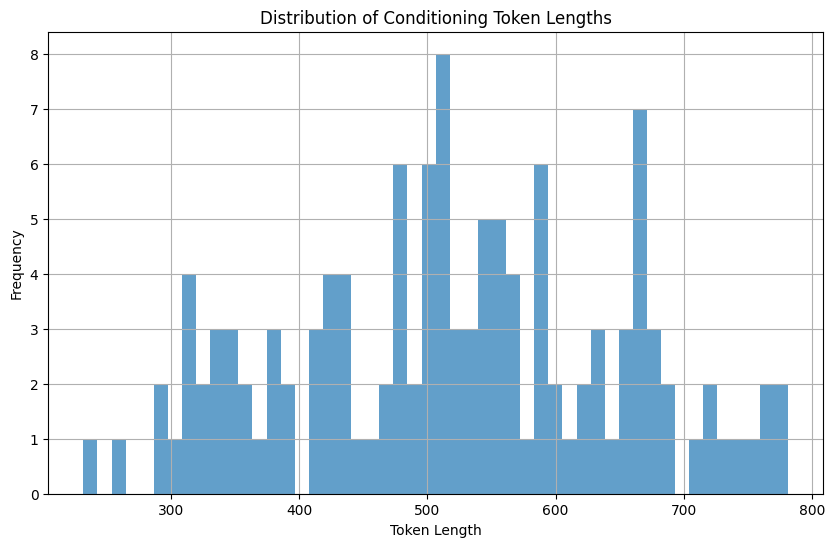


--- 'Order (GT)' 토큰 길이 통계 ---
총 분석된 샘플 수: 123
최소 토큰 길이: 37
최대 토큰 길이: 512
평균 토큰 길이: 213.90
중앙값 토큰 길이: 215.0
90 백분위수: 364.40
95 백분위수: 386.00
99 백분위수: 483.02


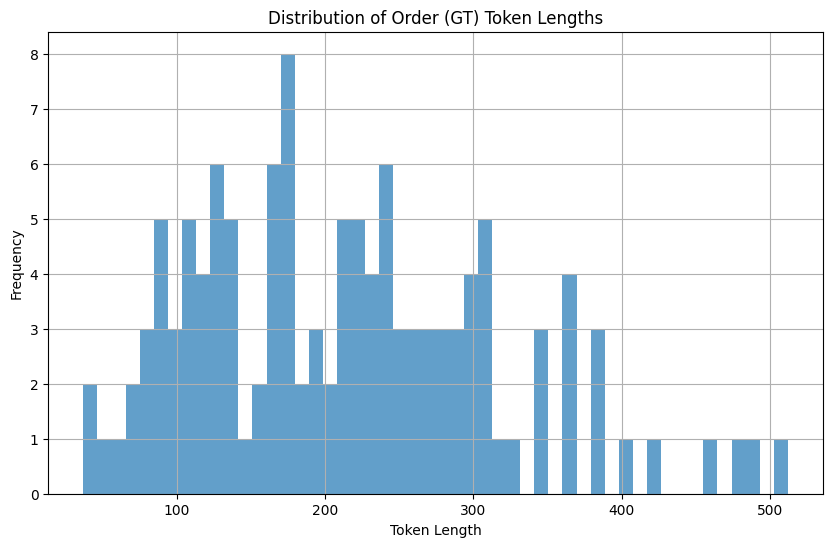


--- 'Combined (Conditioning + SEP + Order)' 토큰 길이 통계 ---
총 분석된 샘플 수: 123
최소 토큰 길이: 270
최대 토큰 길이: 1258
평균 토큰 길이: 734.85
중앙값 토큰 길이: 745.0
90 백분위수: 1011.40
95 백분위수: 1103.30
99 백분위수: 1147.56


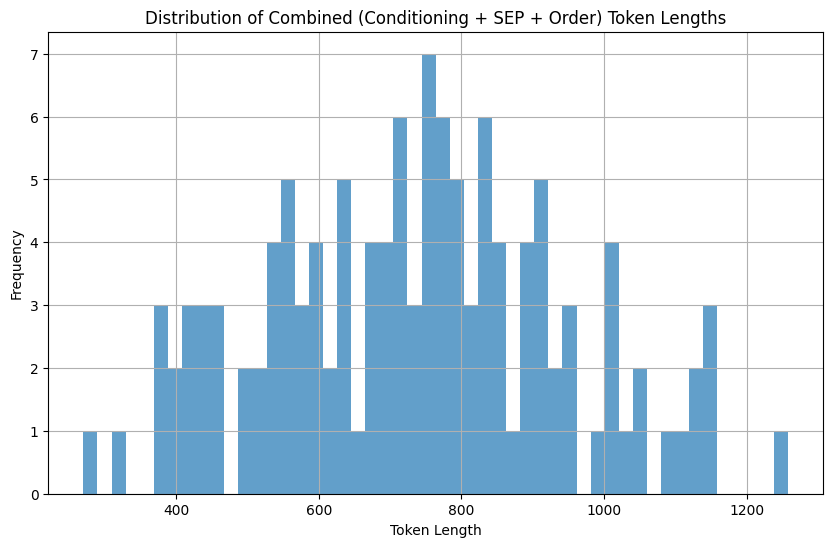

In [7]:
# 새로운 ipynb 파일의 첫 번째 셀들

# 필요한 라이브러리 임포트
import sys
import os
import pandas as pd
import numpy as np
import torch
from transformers import GPT2TokenizerFast
import matplotlib.pyplot as plt # 히스토그램용

# --- 경로 설정 및 기본 객체 로드 (필요시) ---
# 이 부분은 이전 노트북에서 모델 로드까지 성공했으므로,
# 여기서는 토크나이저만 새로 로드하거나, 필요시 이전 객체를 활용할 수 있습니다.
# 간단하게 토크나이저만 다시 로드하는 것으로 진행합니다.

print(f"Initial working directory: {os.getcwd()}")
# SEDD 레포지토리 루트로 작업 디렉토리 변경 (필요시 경로 수정)
repo_path = '/workspace/Score-Entropy-Discrete-Diffusion' # 사용자 환경에 맞게 수정
if os.path.exists(repo_path) and os.path.isdir(repo_path) and os.getcwd() != repo_path:
    os.chdir(repo_path)
    print(f"Changed working directory to: {os.getcwd()}")
sys.path.append(os.getcwd())


# --- 토크나이저 로드 ---
try:
    tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token # PAD 토큰 설정
    print("GPT-2 토크나이저 로드 완료.")
    print(f"EOS token: '{tokenizer.eos_token}', ID: {tokenizer.eos_token_id}")
    print(f"PAD token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
except Exception as e:
    print(f"토크나이저 로드 중 오류 발생: {e}")
    tokenizer = None

# --- 데이터 파일 경로 ---
data_file_path = 'sampledata/processed_dataset.csv' # 실제 파인튜닝 시 전체 파일명으로 변경

# --- 데이터 로드 ---
try:
    df_processed_data = pd.read_csv(data_file_path)
    print(f"\n'{data_file_path}' 파일 로드 완료. Shape: {df_processed_data.shape}")
    print("\n데이터 샘플 (상위 3개):")
    print(df_processed_data.head(3))
except FileNotFoundError:
    print(f"Error: CSV 파일을 찾을 수 없습니다. 경로를 확인하세요: {data_file_path}")
    df_processed_data = pd.DataFrame()
except Exception as e:
    print(f"데이터 로드 중 오류 발생: {e}")
    df_processed_data = pd.DataFrame()

# --- 토큰 길이 분석 ---
if not df_processed_data.empty and tokenizer:
    token_lengths_conditioning = []
    token_lengths_order = []
    token_lengths_combined = []
    
    sep_token_str = tokenizer.eos_token 

    print(f"\n각 샘플 토큰화 진행 중 (구분자: '{sep_token_str}')...")
    for index, row in df_processed_data.iterrows():
        conditioning_text = str(row['conditioning'])
        order_text = str(row['order']) # 컬럼명이 'output'에서 'order'로 변경된 것을 반영
        
        combined_text = conditioning_text + sep_token_str + order_text
        
        tokens_conditioning = tokenizer(conditioning_text, add_special_tokens=False)['input_ids']
        tokens_order = tokenizer(order_text, add_special_tokens=False)['input_ids']
        tokens_combined = tokenizer(combined_text, add_special_tokens=False)['input_ids']
        
        token_lengths_conditioning.append(len(tokens_conditioning))
        token_lengths_order.append(len(tokens_order))
        token_lengths_combined.append(len(tokens_combined))
        
        if index < 2: # 처음 2개 샘플에 대해서만 상세 정보 출력
            print(f"\n--- 샘플 {index+1} ---")
            print(f"Conditioning Text (일부): '{conditioning_text[:100]}...' (토큰 수: {len(tokens_conditioning)})")
            print(f"Order Text (일부): '{order_text[:100]}...' (토큰 수: {len(tokens_order)})")
            print(f"Combined Text (일부): '{combined_text[:150]}...' (토큰 수: {len(tokens_combined)})")
            print(f"토큰화된 Combined (처음 10개): {tokens_combined[:10]}")
            print(f"디코딩된 Combined (처음 10개): {[tokenizer.decode([tid]) for tid in tokens_combined[:10]]}")


    def print_token_stats(lengths, name):
        if lengths:
            print(f"\n--- '{name}' 토큰 길이 통계 ---")
            print(f"총 분석된 샘플 수: {len(lengths)}")
            print(f"최소 토큰 길이: {np.min(lengths)}")
            print(f"최대 토큰 길이: {np.max(lengths)}")
            print(f"평균 토큰 길이: {np.mean(lengths):.2f}")
            print(f"중앙값 토큰 길이: {np.median(lengths)}")
            print(f"90 백분위수: {np.percentile(lengths, 90):.2f}")
            print(f"95 백분위수: {np.percentile(lengths, 95):.2f}")
            print(f"99 백분위수: {np.percentile(lengths, 99):.2f}")
            
            plt.figure(figsize=(10, 6))
            plt.hist(lengths, bins=50, alpha=0.7)
            plt.title(f'Distribution of {name} Token Lengths')
            plt.xlabel('Token Length')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
        else:
            print(f"'{name}'에 대한 토큰 길이를 분석할 데이터가 없습니다.")

    print_token_stats(token_lengths_conditioning, "Conditioning")
    print_token_stats(token_lengths_order, "Order (GT)")
    print_token_stats(token_lengths_combined, "Combined (Conditioning + SEP + Order)")

else:
    if df_processed_data.empty:
        print(f"오류: '{data_file_path}' 파일이 비어 있거나 로드되지 않았습니다.")
    if not tokenizer:
        print("오류: 토크나이저가 성공적으로 로드되지 않아 분석을 진행할 수 없습니다.")

In [ ]:
# 새로운 ipynb 파일의 파인튜닝 코드 셀들

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import json
from transformers import GPT2TokenizerFast # 명시적으로 임포트

# SEDD 레포지토리의 유틸리티 함수 임포트
# 경로 설정 (이 ipynb 파일이 Score-Entropy-Discrete-Diffusion 폴더 내에 있다고 가정)
print(f"Initial working directory: {os.getcwd()}")
if not os.path.basename(os.getcwd()) == 'Score-Entropy-Discrete-Diffusion':
    repo_path = '/workspace/Score-Entropy-Discrete-Diffusion' # 사용자 환경에 맞게 수정
    if os.path.exists(repo_path) and os.path.isdir(repo_path):
        os.chdir(repo_path)
        print(f"Changed working directory to: {os.getcwd()}")
    else:
        print(f"Warning: Repository path '{repo_path}' not found. 파이썬 모듈 임포트에 문제가 생길 수 있습니다.")
sys.path.append(os.getcwd()) # 현재 디렉토리를 sys.path에 추가

import losses 
from model import utils as mutils
import sampling
from load_model import load_model # load_model.py 임포트

# --- 전역 변수 및 하이퍼파라미터 ---
DATA_FILE_PATH = 'sampledata/processed_dataset.csv'
MODEL_SAVE_DIR = '100epoch_finetuned_sedd_model'
MAX_SEQ_LENGTH = 1024
LEARNING_RATE = 5e-5
NUM_EPOCHS = 100
BATCH_SIZE = 4 # A100 80GB에서 이 값은 더 늘릴 수 있습니다. 우선 테스트용.
ACCUMULATION_STEPS = 4

SAVE_EVERY_N_STEPS = 100
LOG_EVERY_N_STEPS = 10

# --- 장치 설정 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 토크나이저 로드 ---
try:
    tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("GPT-2 토크나이저 로드 완료.")
    SEP_TOKEN = tokenizer.eos_token # 구분자 설정
    print(f"EOS/SEP token: '{SEP_TOKEN}', ID: {tokenizer.eos_token_id}")
    print(f"PAD token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
except Exception as e:
    print(f"토크나이저 로드 중 오류 발생: {e}")
    tokenizer = None
    SEP_TOKEN = "<|endoftext|>" # Fallback

# --- 모델 로드 ---
if tokenizer: # 토크나이저 로드가 성공했을 경우에만 모델 로드 시도
    try:
        model_path_load = "louaaron/sedd-small" # HuggingFace Hub 모델 경로
        print(f"Loading model from: {model_path_load}")
        score_model, graph, noise = load_model(model_path_load, device)
        print("SEDD 모델, graph, noise 객체 로드 완료.")
    except Exception as e:
        print(f"SEDD 모델 로드 중 오류 발생: {e}")
        score_model, graph, noise = None, None, None
else:
    print("토크나이저 로드 실패로 모델 로드를 진행하지 않습니다.")
    score_model, graph, noise = None, None, None


# --- 데이터셋 클래스 정의 (이전과 동일) ---
class ProductionPlanningDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, sep_token):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len
        self.sep_token = sep_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        conditioning_text = str(row['conditioning'])
        order_text = str(row['order'])
        combined_text = conditioning_text + self.sep_token + order_text
        
        inputs = self.tokenizer.encode_plus(
            combined_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)
        return {'input_ids': input_ids, 'attention_mask': attention_mask}

# --- 데이터 로드 및 전처리 (모델 로드 성공 시에만 진행) ---

print(f"\n데이터 로딩: {DATA_FILE_PATH}")
df_train = pd.read_csv(DATA_FILE_PATH)
print(f"로드된 데이터 shape: {df_train.shape}")

train_dataset = ProductionPlanningDataset(df_train, tokenizer, MAX_SEQ_LENGTH, SEP_TOKEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 

print(f"데이터셋 및 데이터로더 준비 완료. 총 샘플 수: {len(train_dataset)}, 총 배치 수: {len(train_dataloader)}")

score_model.to(device) 
score_model.train()    

optimizer = optim.AdamW(score_model.parameters(), lr=LEARNING_RATE)
# 수정된 부분: graph.to(device) 제거
loss_fn_sedd = losses.get_loss_fn(noise.to(device), graph, train=True) # noise는 nn.Module이므로 .to(device) 가능

print("모델, 옵티마이저, 손실 함수 설정 완료.")

In [ ]:
# ... (파인튜닝 코드 상단, 하이퍼파라미터 정의 등은 동일) ...

# --- 학습 루프 ---
print("\n실제 파인튜닝 학습 루프 시작...")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
global_step = 0
all_step_losses = [] # 각 스텝별 Loss 기록을 위한 리스트
all_epoch_avg_losses = [] # 각 에폭별 평균 Loss 기록을 위한 리스트

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    epoch_loss_sum = 0.0 
    num_batches_epoch = 0
    
    optimizer.zero_grad() 

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch_idx, batch_data in enumerate(progress_bar):
        input_ids_batch = batch_data['input_ids'].to(device)
        
        loss = loss_fn_sedd(score_model, input_ids_batch)
        
        if isinstance(loss, list) or (isinstance(loss, torch.Tensor) and loss.ndim > 0 and loss.numel() > 1) :
            loss = loss.mean() 

        loss_unscaled = loss.item() # 현재 배치의 스케일링 전 loss (그래디언트 축적 고려 전)
        
        # 그래디언트 축적
        loss_for_backward = loss / ACCUMULATION_STEPS # backward를 위한 loss
        loss_for_backward.backward()
        
        # epoch_loss_sum에는 스케일링 전 원래 loss를 더함 (평균 계산용)
        epoch_loss_sum += loss_unscaled 
        num_batches_epoch +=1

        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_dataloader):
            torch.nn.utils.clip_grad_norm_(score_model.parameters(), 1.0) 
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            
            # 스텝별 Loss 기록 (옵티마이저 스텝이 실행될 때의 Loss)
            # ACCUMULATION_STEPS 동안의 평균 Loss를 기록하거나, 마지막 배치의 loss_unscaled를 사용할 수 있음.
            # 여기서는 ACCUMULATION_STEPS 동안의 평균 loss를 계산해서 기록 (더 안정적)
            accumulated_loss_avg = epoch_loss_sum / num_batches_epoch if num_batches_epoch > 0 else 0 # 현재까지 진행된 배치의 평균
            # 또는 직전 ACCUMULATION_STEPS 동안의 평균을 계산하려면 별도 변수 필요
            # 간편하게는 마지막 loss_unscaled를 기록할 수도 있음: all_step_losses.append(loss_unscaled)
            # 여기서는 global_step이 업데이트 될 때의 "현재까지 에폭 평균 loss"를 기록 (근사치)
            current_step_loss_for_log = epoch_loss_sum / num_batches_epoch 
            all_step_losses.append(current_step_loss_for_log)


            if global_step % LOG_EVERY_N_STEPS == 0:
                progress_bar.set_postfix(avg_epoch_loss=f"{current_step_loss_for_log:.4f}", last_batch_loss=f"{loss_unscaled:.4f}")
            
            if global_step % SAVE_EVERY_N_STEPS == 0:
                save_path = os.path.join(MODEL_SAVE_DIR, f"model_step_{global_step}.pt")
                torch.save(score_model.state_dict(), save_path)
                print(f"모델 저장 완료: {save_path} (Step: {global_step}, Avg Epoch Loss: {current_step_loss_for_log:.4f})")
    
    avg_epoch_loss_final = epoch_loss_sum / len(train_dataloader) if len(train_dataloader) > 0 else 0
    all_epoch_avg_losses.append(avg_epoch_loss_final) # 에폭별 평균 Loss 기록
    print(f"Epoch {epoch+1} 완료. 최종 평균 Loss: {avg_epoch_loss_final:.4f}")
    
    epoch_save_path = os.path.join(MODEL_SAVE_DIR, f"model_epoch_{epoch+1}.pt")
    torch.save(score_model.state_dict(), epoch_save_path)
    print(f"모델 저장 완료 (Epoch {epoch+1}): {epoch_save_path}")

print("\n파인튜닝 학습 루프 종료.")
tokenizer.save_pretrained(MODEL_SAVE_DIR)
print(f"토크나이저 저장 완료: {MODEL_SAVE_DIR}")

# 학습 루프 후 all_step_losses 와 all_epoch_avg_losses 리스트를 다음 셀에서 사용


In [ ]:
# 새로운 셀: 학습 Loss 그래프 시각화

import matplotlib.pyplot as plt
import numpy as np

# 이전 셀에서 all_step_losses 와 all_epoch_avg_losses 리스트가 생성되었다고 가정

if 'all_step_losses' in globals() and all_step_losses:
    plt.figure(figsize=(12, 6))
    
    # 스텝별 Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(all_step_losses, label='Average Loss per Global Step (approx.)')
    plt.xlabel('Global Step (Optimizer Updates)')
    plt.ylabel('Average Loss')
    plt.title('Training Loss per Global Step')
    plt.legend()
    plt.grid(True)
    
    if 'all_epoch_avg_losses' in globals() and all_epoch_avg_losses:
        # 에폭별 평균 Loss 그래프
        plt.subplot(1, 2, 2)
        # x축을 epoch 번호로 (1부터 시작)
        epochs = np.arange(1, len(all_epoch_avg_losses) + 1)
        plt.plot(epochs, all_epoch_avg_losses, label='Average Loss per Epoch', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.title('Training Loss per Epoch')
        plt.xticks(epochs) # x축 눈금을 정수 에폭 번호로
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout() # 그래프들이 겹치지 않도록 레이아웃 조정
    plt.show()
else:
    print("기록된 Loss 데이터(all_step_losses)가 없습니다. 학습을 먼저 실행해주세요.")

In [20]:
# 새로운 셀: 저장된 체크포인트 모델을 사용한 Infilling 추론

import torch
import pandas as pd
import os
from transformers import GPT2TokenizerFast # 명시적으로 임포트
import sampling # sampling.py 임포트
from model import SEDD # SEDD 클래스 임포트
from omegaconf import OmegaConf # OmegaConf 임포트
# from load_model import load_model as load_model_util # 필요시 config 로드용

# --- 설정값 ---
MODEL_CHECKPOINT_DIR = '100epoch_finetuned_sedd_model' # 학습된 모델이 저장된 디렉토리
# 로드할 체크포인트 파일명 (예: 'model_epoch_20.pt' 또는 'model_step_XXX.pt')
CHECKPOINT_FILENAME = 'model_epoch_29.pt' 
DEVICE_INFER = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_SEQ_LENGTH_INFER = 1024 # 학습 시 사용한 MAX_SEQ_LENGTH와 동일하게 설정
DATA_FILE_PATH_FOR_INFERENCE_PREFIX = 'sampledata/processed_dataset.csv' # Prefix 가져올 데이터 파일

# --- 토크나이저 로드 (저장된 것 사용) ---
try:
    tokenizer_infer = GPT2TokenizerFast.from_pretrained(MODEL_CHECKPOINT_DIR)
    print(f"저장된 토크나이저 로드 완료: {MODEL_CHECKPOINT_DIR}")
    SEP_TOKEN_INFER = tokenizer_infer.eos_token
    print(f"추론 시 사용할 SEP_TOKEN: '{SEP_TOKEN_INFER}'")
except Exception as e:
    print(f"저장된 토크나이저 로드 실패: {e}. 기본 GPT-2 토크나이저를 사용합니다.")
    tokenizer_infer = GPT2TokenizerFast.from_pretrained('gpt2')
    if tokenizer_infer.pad_token is None: tokenizer_infer.pad_token = tokenizer_infer.eos_token
    SEP_TOKEN_INFER = tokenizer_infer.eos_token


# --- 모델 구조를 위한 Config 로드 ---
# SEDD 모델을 인스턴스화하려면 config 객체가 필요합니다.
# 가장 간단한 방법은 사전학습 모델("louaaron/sedd-small")의 config를 사용하는 것입니다.
# 또는 학습 시 사용했던 config를 저장해두었다가 로드할 수도 있습니다.
# 여기서는 louaaron/sedd-small의 config를 가져와서 사용합니다.

# 임시로 모델을 로드하여 config만 가져오기 (메모리 효율을 위해 바로 삭제)
# 만약 학습 셀에서 graph, noise 객체가 살아있다면 그것을 사용해도 됩니다.
try:
    from load_model import load_model as load_model_internal # 이름 충돌 피하기
    temp_model_for_config, graph_infer, noise_infer = load_model_internal("louaaron/sedd-small", DEVICE_INFER)
    model_config_infer = temp_model_for_config.config # OmegaConf 객체
    del temp_model_for_config # 메모리에서 즉시 해제
    print("추론을 위한 모델 config 로드 완료.")
except Exception as e:
    print(f"모델 config 로드 실패: {e}. 추론 진행이 어려울 수 있습니다.")
    model_config_infer, graph_infer, noise_infer = None, None, None


# --- 저장된 모델 로드 ---
if model_config_infer:
    inference_model = SEDD(model_config_infer) # config를 사용하여 모델 인스턴스 생성
    checkpoint_path = os.path.join(MODEL_CHECKPOINT_DIR, CHECKPOINT_FILENAME)
    try:
        inference_model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE_INFER))
        inference_model.to(DEVICE_INFER)
        inference_model.eval() # 추론 모드로 설정
        print(f"체크포인트 모델 로드 완료: {checkpoint_path}")
    except FileNotFoundError:
        print(f"오류: 체크포인트 파일을 찾을 수 없습니다 - {checkpoint_path}")
        inference_model = None
    except Exception as e:
        print(f"체크포인트 모델 로드 중 오류 발생: {e}")
        inference_model = None
else:
    inference_model = None

# --- Infilling 추론 실행 ---
if inference_model and tokenizer_infer and graph_infer and noise_infer:
    try:
        df_infer_prefix_source = pd.read_csv(DATA_FILE_PATH_FOR_INFERENCE_PREFIX)
        if not df_infer_prefix_source.empty:
            # 추론할 conditioning 텍스트 (예시로 첫 번째 데이터 사용)
            example_conditioning_text_infer = str(df_infer_prefix_source.iloc[0]['conditioning'])
            prefix_text_for_inference_infer = example_conditioning_text_infer + SEP_TOKEN_INFER
            
            print(f"\n추론 Prefix (일부): '{prefix_text_for_inference_infer[:150]}...'")

            prefix_ids_infer_list = tokenizer_infer.encode(prefix_text_for_inference_infer, add_special_tokens=False)
            num_prefix_tokens_infer = len(prefix_ids_infer_list)
            print(f"실제 Prefix 토큰 길이: {num_prefix_tokens_infer}")

            inference_total_sequence_length_infer = MAX_SEQ_LENGTH_INFER
            
            if num_prefix_tokens_infer >= inference_total_sequence_length_infer:
                print(f"오류: Prefix 토큰 길이({num_prefix_tokens_infer})가 전체 추론 시퀀스 길이({inference_total_sequence_length_infer})보다 크거나 같습니다.")
            else:
                max_order_tokens_to_generate_infer = inference_total_sequence_length_infer - num_prefix_tokens_infer
                print(f"모델이 생성할 Order 부분의 최대 토큰 길이: {max_order_tokens_to_generate_infer}")

                num_inference_samples_infer = 1
                sampling_steps_infer = 128 
                sampling_eps_infer = 1e-5

                prefix_ids_tensor_infer = torch.tensor(prefix_ids_infer_list, device=DEVICE_INFER).unsqueeze(0).expand(num_inference_samples_infer, -1)

                def infilling_proj_fun_infer(x_t_sampled):
                    x_t_sampled[:, :num_prefix_tokens_infer] = prefix_ids_tensor_infer
                    return x_t_sampled
                
                try:
                    if hasattr(inference_model, 'config') and inference_model.config and hasattr(inference_model.config, 'sampling'):
                         predictor_type_infer_detail = inference_model.config.sampling.predictor
                         denoise_sampling_infer_detail = inference_model.config.sampling.noise_removal
                    else: 
                        print("Warning: 로드된 모델 config에 sampling 정보가 없거나 config 객체 자체가 없습니다. 기본 샘플링 파라미터를 사용합니다.")
                        predictor_type_infer_detail = 'euler'
                        denoise_sampling_infer_detail = True
                    
                    current_inference_sampling_fn = sampling.get_pc_sampler(
                        graph=graph_infer, # graph, noise도 device로 전달 확인
                        noise=noise_infer.to(DEVICE_INFER),
                        batch_dims=(num_inference_samples_infer, inference_total_sequence_length_infer),
                        predictor=predictor_type_infer_detail,
                        steps=sampling_steps_infer,
                        denoise=denoise_sampling_infer_detail,
                        eps=sampling_eps_infer,
                        device=DEVICE_INFER,
                        proj_fun=infilling_proj_fun_infer
                    )
                    print("추론 샘플링 함수 준비 완료.")

                    with torch.no_grad():
                        generated_ids_for_inference = current_inference_sampling_fn(inference_model)
                        generated_ids_for_inference = infilling_proj_fun_infer(generated_ids_for_inference) 

                    print("\n--- 생성된 생산 계획 (Order 부분) ---")
                    for i, full_ids in enumerate(generated_ids_for_inference):
                        order_part_ids_infer = full_ids[num_prefix_tokens_infer:]
                        order_part_text_infer = tokenizer_infer.decode(order_part_ids_infer, skip_special_tokens=True)
                        print(f"\n--- 추론 샘플 {i+1} (생성된 Order 부분) ---")
                        print(order_part_text_infer.strip())
                        print("-" * 70)
                except Exception as e_samp:
                    print(f"추론 샘플링 중 오류 발생: {e_samp}")
                    import traceback
                    traceback.print_exc()
        else:
            print(f"Prefix를 가져올 데이터 파일({DATA_FILE_PATH_FOR_INFERENCE_PREFIX})이 비어있습니다.")
    except FileNotFoundError:
        print(f"Prefix를 가져올 데이터 파일을 찾을 수 없습니다: {DATA_FILE_PATH_FOR_INFERENCE_PREFIX}")
    except Exception as e_outer:
        print(f"추론 준비 중 오류 발생: {e_outer}")
        import traceback
        traceback.print_exc()
else:
    print("오류: 추론을 위한 모델, 토크나이저, 그래프 또는 노이즈 객체 로드에 실패했습니다.")

저장된 토크나이저 로드 실패: Can't load tokenizer for '100epoch_finetuned_sedd_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '100epoch_finetuned_sedd_model' is the correct path to a directory containing all relevant files for a GPT2TokenizerFast tokenizer.. 기본 GPT-2 토크나이저를 사용합니다.
추론을 위한 모델 config 로드 완료.
체크포인트 모델 로드 완료: 100epoch_finetuned_sedd_model/model_epoch_29.pt

추론 Prefix (일부): 'Order information
• item15, right? 318? You can do it by May 13th, 2021, and the unit price is 25,870 won. Oh, and the inspection product.
• Oh, I jus...'
실제 Prefix 토큰 길이: 773
모델이 생성할 Order 부분의 최대 토큰 길이: 251
추론 샘플링 함수 준비 완료.

--- 생성된 생산 계획 (Order 부분) ---

--- 추론 샘플 1 (생성된 Order 부분) ---
item01 machine08 1.25
• item01 machine10 4.42
• item83 machine09.1 7.32
• item8314 9.42
• item83 machine21 8.35
• item83 machine22 8.34
• item83 machine23 11.44
• item81 machine29 10.45
• item81 machine33 11.17
• item81 mach